In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

from IPython.display import HTML

import sys
sys.path.append("../src")
import util

In [3]:
subject = "P01"
models = ["SQuAD", "SST", "QQP", "MNLI", "LM_scrambled", "LM_pos"]
layers = [2, 5, 8, 11]

n_filter = 1000

In [4]:
brain_path = "../data/brains/%s/examples_384sentences.mat" % subject

In [5]:
subject_images, coords = util.load_brain_data(brain_path, downsample=3, ret_coords=True)

In [6]:
def get_errors(model):
    """
    Get prediction errors for the given model at different layers.
    """
    decoder_pred_path = "/om2/user/jgauthie/scratch/nn-decoding/models/encoders/encodings.finetune-250.uncased_L-12_H-768_A-12.%s-run1-250-layer%%i-%s.whole-brain-down3.pred.npy" % (model, subject)
    predictions = [np.load(decoder_pred_path % layer) for layer in layers]
    errors = np.array([mean_squared_error(subject_images, predictions_i, multioutput="raw_values")
                       for predictions_i in predictions])
    return errors

In [7]:
def threshold_and_normalize_errors(errors, n=1000):
    """
    Args:
        errors: `n_layers * n_examples` error matrix
        
    Returns:
        errors_filtered: `n_layers * n` error matrix, normalized per super-voxel
        coords_filtered: `n * 3` matrix specifying coordinates of each super-voxel
    """
    best = errors.min(axis=0).argsort()[:n]
    errors_filtered, coords_filtered = errors[:, best], coords[best]
    
    # Normalize errors within super-voxel
    errors_filtered -= errors_filtered.min(axis=0)
    errors_filtered /= errors_filtered.max(axis=0)
    
    return errors_filtered, coords_filtered

In [8]:
all_errors = {model: threshold_and_normalize_errors(get_errors(model)) for model in tqdm_notebook(models)}

## `matplotlib` helpers

In [16]:
def cuboid_data(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt(positions, sizes=None, colors=None, alpha=None, edgecolors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data(p, size=s) )
        
    pc = Poly3DCollection(np.concatenate(g), **kwargs)
    if alpha is not None:
        pc.set_alpha(alpha)
    if edgecolors is not None:
        pc.set_edgecolors(edgecolors)
    pc.set_facecolors(np.repeat(colors, 6, axis=0))
    return pc

## Animation

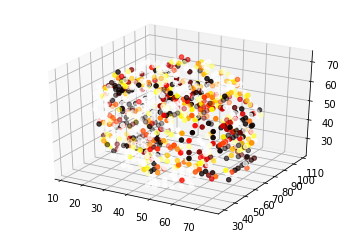

In [19]:
animate_model = "QQP"
errors_filtered, coords_filtered = all_errors[animate_model]

def render_errors(layer_idx):
    cmap = plt.get_cmap("hot")
    ax.clear()
    ax.scatter(coords_filtered[:, 0], coords_filtered[:, 1], coords_filtered[:, 2], c=errors_filtered[layer_idx], cmap=cmap)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim((0, coords_filtered[:, 0].max()))
ax.set_ylim((0, coords_filtered[:, 1].max()))
ax.set_zlim((0, coords_filtered[:, 2].max()))
graph = ax.scatter(*np.tile(0, (3, n_filter)))
ani = FuncAnimation(fig, render_errors, 4, interval=200, blit=False, repeat=False)
HTML(ani.to_html5_video())

## Full grid

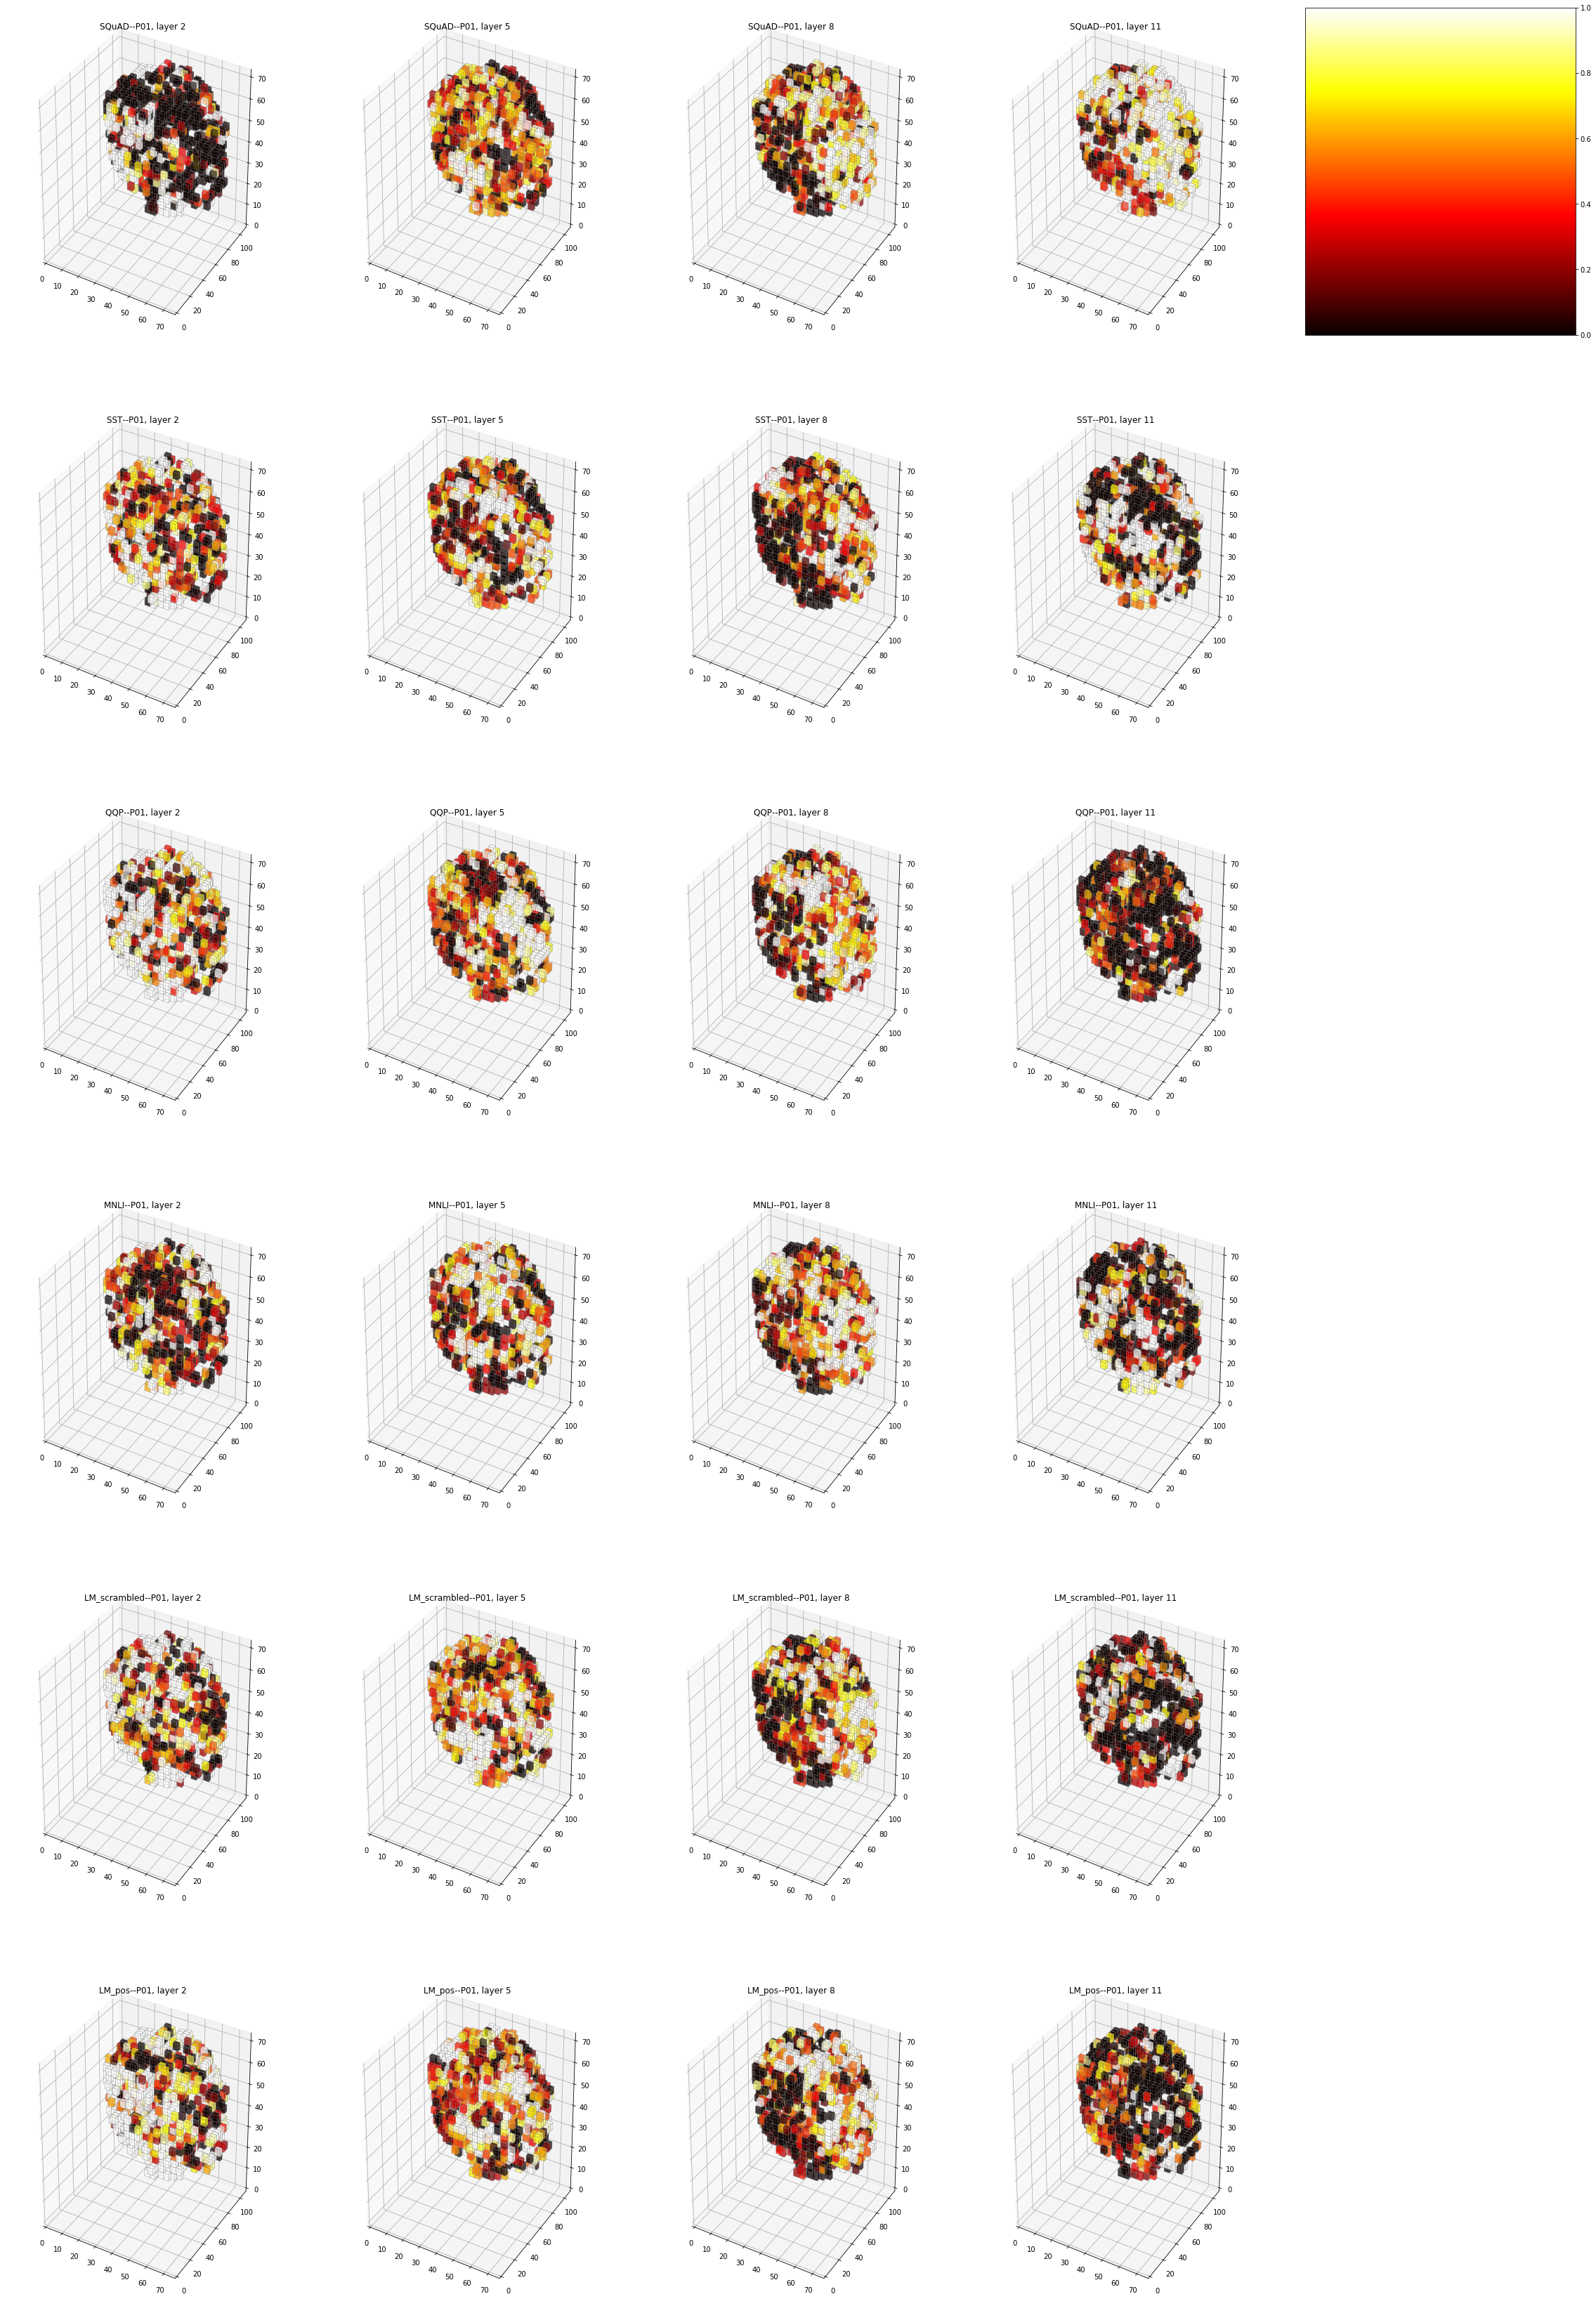

In [17]:
n_rows = len(models)
n_cols = len(layers) + 1
fig = plt.figure(figsize=(40, 10 * n_rows))
cmap = plt.get_cmap("hot")

for model_idx, model in enumerate(models):
    for layer_idx, layer in enumerate(layers):
        errors_filtered, coords_filtered = all_errors[model]
        
        ax = fig.add_subplot(n_rows, n_cols, 1 + layer_idx + model_idx * n_cols, projection="3d")
        ax.set_xlim((0, coords_filtered[:, 0].max()))
        ax.set_ylim((0, coords_filtered[:, 1].max()))
        ax.set_zlim((0, coords_filtered[:, 2].max()))
        
        poly_collection = plotCubeAt(coords_filtered,
                                     sizes=np.tile([(3, 3, 3)], (len(coords_filtered), 1)),
                                     colors=[cmap(v) for v in errors_filtered[layer_idx]],
                                     linewidths=0.5, edgecolors="gray", alpha=0.5)
        ax.add_collection3d(poly_collection)

        ax.set_title("%s--%s, layer %d" % (model, subject, layer))
    
ax = fig.add_subplot(n_rows, n_cols, len(layers) + 1)
from matplotlib.colorbar import ColorbarBase
ColorbarBase(ax, cmap=cmap)